# Segmenting and Clustering Neighbourhoods in the City of Toronto

**Project Title:** DP0701EN-3-3-2-Neighbourhoods-Toronto v1.0<br /> 
**Course:** Applied Data Science Capstone, Cognitive Class.ai<br /> 
**Program:** IBM Data Science Professional Certificate<br />

# Introduction
This notebook contains a basic exploration, segmentation and clustering of neighbourhoods in Toronto, Canada. Firstly, we will download any relevant dependancies. Secondly, we will scrape data from the Wikipedia page (<a href="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M">List of postal codes of Canada: M</a>). Then we wrangle the data, clean it, and then read it into a pandas dataframe, so that it is in a structured format. Next we will convert addresses into their equivalent latitude and longitude values and assign geographical coordinates. 

Thirdly, we will use the Foursquare API to explore neighborhoods in Toronto and begin inital segmentation. Foursquare's API is a good resource to leverage for additional neighbourhood data in Toronto. During this stage, we will use the explore function to get the most common venue categories in each neighborhood. Forthly, we will use the k-means clustering algorithm to group the neighborhoods into clusters. Finally, we will use the Folium library to visualize the neighbourhoods in Toronto and examine their emerging clusters.

## Grammar and Spelling Notation
In the original notebook this one emulates, there are two spellings used interchangably for the word, "neighbourhood", also referred to as "neighborhood". In order to acheive consistency, this notebook will default to only one of the two spellings. It is important to consider the main topic of this exercise is an analysis of Toronto, a major Canadian city. As such, it has been established that the resulting analysis is targeted for dissemination by a primarily Canadian audience. Therefore, the author has defaulted to the classic Canadian English spelling - neighbourhood - and this spelling is used forthwith. 


# Table of Contents 

1. <a href="#item1">Download Dependancies: Import Modules, Packages and Libraries</a>

2. <a href="#item2">Aquisition of Data and Initial Dataframe Construction</a>

3. <a href="#item3">Exploration of Neighbourhoods in Toronto</a>

4. <a href="#item4">Analysis of Each Neighbourhood</a>

5. <a href="#item5">Cluster of Neighbourhoods</a>    
    
6. <a href="#item6">Examination of Clusters</a>        

6. <a href="#item6">Conclusion</a>  

# 1. Download Dependancies: Import Modules, Packages and Libraries <a id='item1'></a>

In [1]:
#Ensure backwards compatibility with Python 2
from __future__ import print_function
print('Whoo-hoo back to the future - backwards compatibility enabled for Python 2')

print()
print('-----')
print()

#numpy - scientific computing library
import numpy as np
print('Load successful! Running numpy version:', np.__version__)

#pandas - primary data structure library
import pandas as pd
#pandas.io.json - normalize semi-structured JSON data into a flat table
from pandas.io.json import json_normalize
print('Load successful! Running pandas version:', pd.__version__)

#seaborn - data visualization library
import seaborn as sns
print('Load successful! Running seaborn version:',sns.__version__)

#matplotlib - 2D plotting library
import matplotlib as mpl
print('Load successful! Running matplotlib version:', mpl.__version__)
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import matplotlib.image as mpimg
import matplotlib.style as style
from matplotlib import rcParams
import matplotlib.pyplot as plt
print('Load successful! Running matplotlib cm, colors, ListedColormap, pyplot, rcParams, image and style')

#seaborn - advanced visualization, regression chats, etc...
import seaborn as sns
print('Load successful! Running seaborn version:', sns.__version__)

#JSON - file encoder and decoder
import json
print('Load successful! Running json version:', json.__version__)

#requests - de facto standard for making HTTP requests
import requests
print('Load successful! Running requests version:', requests.__version__)

#scikit.learn.KMeans - Clustering of unlabeled data using K-Means algorithm
#The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares
from sklearn.cluster import KMeans
print('Load successful! Running scikit learn K-Means module')

#scipy.stats.norm - normal continuous random variable
from scipy.stats import norm
print('Load successful! Running scipy stats norm module')

print()
print('-----')
print()

print('Installing Folium...')
#folium - interactive maps library
!pip install --user folium
import folium as fm
print('Load successful! Running folium version:', fm.__version__)

print()
print('-----')
print()

print('I’d like to complain… but all libraries and modules are running!')

Whoo-hoo back to the future - backwards compatibility enabled for Python 2

-----

Load successful! Running numpy version: 1.15.4
Load successful! Running pandas version: 0.24.1
Load successful! Running seaborn version: 0.9.0
Load successful! Running matplotlib version: 3.0.2
Load successful! Running matplotlib cm, colors, ListedColormap, pyplot, rcParams, image and style
Load successful! Running seaborn version: 0.9.0
Load successful! Running json version: 2.0.9
Load successful! Running requests version: 2.21.0
Load successful! Running scikit learn K-Means module
Load successful! Running scipy stats norm module

-----

Installing Folium...
     |████████████████████████████████| 92kB 7.3MB/s eta 0:00:011
Load successful! Running folium version: 0.10.1

-----

I’d like to complain… but all libraries and modules are running!


___

# 2. Aquisition of Data and Initial Dataframe Construction <a id='item2'></a>

Per Wikipedia, this is a list of postal codes in Canada where the first letter is M. Postal codes beginning with M are located within the city of Toronto in the province of Ontario. Only the first three characters are listed, corresponding to the Forward Sortation Area.

In [2]:
df_PostalCodes=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

print('Initial data shape:',df_PostalCodes.shape)
print('This dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_PostalCodes['Borough'].unique()),
        df_PostalCodes.shape[0]
    )
)
df_PostalCodes.head(3)

Initial data shape: (287, 3)
This dataframe has 12 boroughs and 287 neighborhoods.


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods


## Data Cleaning

First, we will remove the records unassigned to a borough. Next, we will combine any neighbourhoods identical postal codes. Lastly, we will replace name of the any unassigned neighbourhoods with names of their borough.

In [3]:
df_Borough_NA=df_PostalCodes[df_PostalCodes.Borough!='Not assigned']
df_Neighbourhood_NA=df_Borough_NA['Neighbourhood'].where(df_Borough_NA['Neighbourhood']!='Not assigned',other=df_Borough_NA['Borough'],axis=0)
df_Clean=pd.concat([df_Borough_NA['Postcode'],df_Borough_NA['Borough'],df_Neighbourhood_NA],axis=1)
df_Clean.head(3)

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Now we will group the dataframe by Postcode and Borough. The resulting dataframe has more than one row per postcode. For this reason, we will concatenate all neighbourhoods into comma separated list.

In [4]:
df_Group=df_Clean.groupby(['Postcode','Borough'])['Neighbourhood'].apply(list).apply(lambda x: ', '.join(x)).to_frame()
df_Group.reset_index(inplace=True)
print('Cleaned data shape:',df_Group.shape)
print('This dataframe has {} boroughs and {} neighbourhoods.'.format(
        len(df_Group['Borough'].unique()),
        df_Group.shape[0]
    )
)
df_Group.head(3)

Cleaned data shape: (103, 3)
This dataframe has 11 boroughs and 103 neighbourhoods.


,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"


## Geographical Coordinates: Add Latitude and Longitude
It's time to get the latitude and the longitude coordinates of each neighbourhood and append as columns to the dataframe. First, we will read in the csv.

In [5]:
df_Geo=pd.read_csv('http://cocl.us/Geospatial_data')
df_Geo.head(3)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711


Next, we will merge the data with the existing dataframe, drop the extra row and format the column name.

In [6]:
toronto_neighbourhoods=pd.merge(df_Group,df_Geo,left_on='Postcode',right_on='Postal Code')
toronto_neighbourhoods.drop('Postal Code',axis=1,inplace=True)
toronto_neighbourhoods.rename(columns={'Postcode':'Postal Code'},inplace=True)
toronto_neighbourhoods.head(3)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711


## Data Shape

Use the .shape method to print the number of rows of your dataframe.

In [7]:
print('The resulting toronto_neighbourhoods dataframe shape is:',toronto_neighbourhoods.shape)

The resulting toronto_neighbourhoods dataframe shape is: (103, 5)


___

# 3. Exploration of Neighbourhoods in Toronto <a id='item3'></a>

Next, we are going to use Foursquare's API to explore the neighbourhoods and beging to segment them.

## Define Foursquare Credentials and Version

In [95]:
@hidden_cell
CLIENT_ID='TCUIW0QQTED5DU4BWMVGBGI0BSLM0MG3UU3HCLD3GH4NQYNI'
CLIENT_SECRET='L3KFLKUHWVZQDSPHQTZT5ONU5ZUN2RZH234TZUWUFXEOKKH0'
VERSION='20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TCUIW0QQTED5DU4BWMVGBGI0BSLM0MG3UU3HCLD3GH4NQYNI
CLIENT_SECRET:L3KFLKUHWVZQDSPHQTZT5ONU5ZUN2RZH234TZUWUFXEOKKH0


## Explore the First Neighbourhood

Get the name of the first neighbourhood.

In [43]:
print('The name of the first neighbourhood we are going to look at is',toronto_neighbourhoods.loc[0,'Neighbourhood'],'located in the',toronto_neighbourhoods.loc[0,'Borough'],'borough.')

The name of the first neighbourhood we are going to look at is Rouge, Malvern located in the Scarborough borough.


Get the neighbourhood's latitude and longitude values.

In [44]:
neighbourhood_latitude=toronto_neighbourhoods.loc[0,'Latitude']
neighbourhood_longitude=toronto_neighbourhoods.loc[0,'Longitude']
neighbourhood_name=toronto_neighbourhoods.loc[0,'Neighbourhood']

print('The latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name,
                                                                   neighbourhood_latitude,
                                                                   neighbourhood_longitude))

The latitude and longitude values of Rouge, Malvern are 43.806686299999996, -79.19435340000001.


## Top Venues in the Rouge, Malvern Neighbourhood

Let's look at the top 100 venues that are in Rouge, Malvern within a radius of 500 meters

In [59]:
LIMIT=100
radius=500
url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)

Clean the json and structure it into a pandas dataframe.

In [60]:
results=requests.get(url).json()

def get_category_type(row):
    try:
        categories_list=row['categories']
    except:
        categories_list=row['venue.categories']
        
    if len(categories_list)==0:
        return None
    else:
        return categories_list[0]['name']

venues=results['response']['groups'][0]['items']
nearby_venues=json_normalize(venues)
filtered_columns=['venue.name','venue.categories','venue.location.lat','venue.location.lng']
nearby_venues=nearby_venues.loc[:, filtered_columns]
nearby_venues['venue.categories']=nearby_venues.apply(get_category_type, axis=1)
#nearby_venues.columns=[col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Wendy's,Fast Food Restaurant,43.807448,-79.199056


In [61]:
print('Foursquare found {} venue(s).'.format(nearby_venues.shape[0]))

Foursquare found 1 venue(s).


## Create Repeatable Process Function

In [62]:
def getNearbyVenues(names,latitudes,longitudes,radius=500):
    
    venues_list=[]
    for name,lat,lng in zip(names,latitudes,longitudes):
        print(name)
            
        url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results=requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues=pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns=['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

nearby_venues.head(3)

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Wendy's,Fast Food Restaurant,43.807448,-79.199056


Now write the code to run the above function on each neighbourhood and create a new dataframe called toronto_venues.

In [63]:
toronto_venues=getNearbyVenues(names=toronto_neighbourhoods['Neighbourhood'],
                               latitudes=toronto_neighbourhoods['Latitude'],
                               longitudes=toronto_neighbourhoods['Longitude']
                               )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

Let's check the size of the resulting dataframe.

In [64]:
print(toronto_venues.shape)
toronto_venues.head(3)

(2209, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place


Let's check how many venues were returned for each neighbourhood.

In [65]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",2,2,2,2,2,2
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",12,12,12,12,12,12
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Downsview North, Wilson Heights",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
Berczy Park,54,54,54,54,54,54


Let's find out how many unique categories can be curated from all the returned venues.

In [66]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 265 uniques categories.


Let's look at the distribution of the data.

## Chart Styling
Set plot style and colors to match the popular Five Thirty Eight website format.

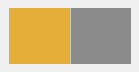

In [53]:
style.use('fivethirtyeight')

colors_gy=['#E5AE38','#8B8B8B']
fte_gy=sns.set_palette(sns.color_palette(colors_gy))
sns.palplot(sns.color_palette())

current_palette=sns.color_palette(colors_gy, n_colors=2)
cmap=ListedColormap(sns.color_palette(current_palette).as_hex())

Let's get a count of the venue categories in each neighbourhood and draw a histogram to get an understanding of how much data we have per neighbourhood.

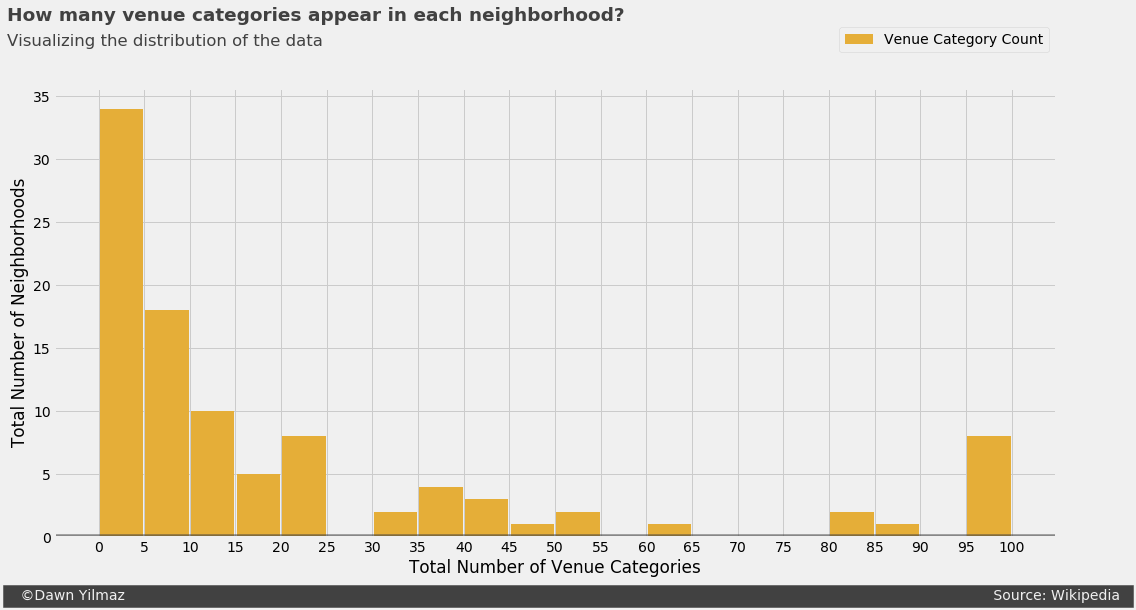

In [67]:
toronto_venues_count=toronto_venues.groupby('Neighborhood').count().reset_index()
toronto_venues_count=toronto_venues_count[['Neighborhood','Venue Category']]
toronto_venues_count.columns=['Neighborhood','Venue Category Count']
bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

fig,ax=plt.subplots(figsize=(16,9),dpi=72)

ax.hist(toronto_venues_count['Venue Category Count'],bins=bins, rwidth=0.95)
plt.axhline(y=0, color='#414141',linewidth=5.5,alpha=.6)
plt.ylabel('Total Number of Neighborhoods')
plt.xlabel('Total Number of Venue Categories')
plt.xticks(bins)
plt.legend(loc='upper right',bbox_to_anchor=(1,1.15))
plt.text(x=-10,y=41,s='How many venue categories appear in each neighborhood?',fontsize=18.5,fontweight='semibold',color='#414141')
plt.text(x=-10,y=39,s='Visualizing the distribution of the data',fontsize=16.5,color='#414141')
plt.text(x=-10,y=-5,s='   ©Dawn Yilmaz                                                                                                                                                                                                 Source: Wikipedia  ',
    fontsize = 14,color='#f0f0f0',backgroundcolor='#414141')
fig.tight_layout()
plt.show()

## Drop Records With Under 5 Venue Categories
Let's find out the exact number of neighborhoods with less than 10 venue categories.

In [68]:
toronto_venues_count=toronto_venues.groupby('Neighborhood').count()
print('There are {} neighborhoods with less than 5 venue categories.'.format(toronto_venues_count[toronto_venues_count['Venue Category'] < 5].shape[0]))

There are 34 neighborhoods with less than 5 venue categories.


In [70]:
drop=toronto_venues_count[toronto_venues_count['Venue Category']<5].index.tolist()
toronto_venues_drop=toronto_venues[~toronto_venues['Neighborhood'].isin(drop)]
toronto_venues=toronto_venues_drop
toronto_venues.groupby('Neighborhood').count().shape

(65, 6)

___

# 4. Analysis of Each Neighbourhood <a id='item4'></a>

Now we are going to use one hot encoding. Afterwards, we will rename the column 'Neighbourhood' which represents a category name to 'Neighborhood Category' to distinguish this column from the 'Neighborhood' column which we want to continue to use as the neighborhood name. Finally, we will move neighborhood column to the first column.

In [71]:
toronto_onehot=pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.rename(columns={'Neighborhood':'Neighborhood Category'},inplace=True)
toronto_onehot['Neighborhood']=toronto_venues['Neighborhood'] 
fixed_columns=[toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot=toronto_onehot[fixed_columns]

print('The shape of the new dataframe is',toronto_onehot.shape)

The shape of the new dataframe is (2110, 250)


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [72]:
toronto_grouped=toronto_onehot.groupby('Neighborhood').mean().reset_index()
print('The shape of the toronto_grouped dataframe is',toronto_grouped.shape)
toronto_grouped.head(3)

The shape of the toronto_grouped dataframe is (65, 250)


,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,...,0.0,0.02,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0
1,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
2,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0


Let's print each neighborhood along with the top 5 most common venues. Let's put that into a pandas dataframe

In [73]:
def return_most_common_venues(row,num_top_venues):
    row_categories=row.iloc[1:]
    row_categories_sorted=row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [74]:
num_top_venues=10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(3)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Steakhouse,Café,Bar,Thai Restaurant,Burger Joint,Bakery,Cosmetics Shop,Breakfast Spot,Asian Restaurant
1,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pizza Place,Grocery Store,Pharmacy,Fried Chicken Joint,Coffee Shop,Discount Store,Sandwich Place,Beer Store,Japanese Restaurant,Fast Food Restaurant
2,"Alderwood, Long Branch",Pizza Place,Skating Rink,Pharmacy,Pub,Dance Studio,Sandwich Place,Coffee Shop,Gym,General Entertainment,Cuban Restaurant


Let's put this into a pandas dataframe. First, let's write a function to sort the venues in descending order.

In [75]:
def return_most_common_venues(row,num_top_venues):
    row_categories=row.iloc[1:]
    row_categories_sorted=row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [76]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(3)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Steakhouse,Café,Bar,Thai Restaurant,Burger Joint,Bakery,Cosmetics Shop,Breakfast Spot,Asian Restaurant
1,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pizza Place,Grocery Store,Pharmacy,Fried Chicken Joint,Coffee Shop,Discount Store,Sandwich Place,Beer Store,Japanese Restaurant,Fast Food Restaurant
2,"Alderwood, Long Branch",Pizza Place,Skating Rink,Pharmacy,Pub,Dance Studio,Sandwich Place,Coffee Shop,Gym,General Entertainment,Cuban Restaurant


In [77]:
neighborhoods_venues_sorted.groupby(['1st Most Common Venue']).size()

1st Most Common Venue
Airport Terminal              1
Bakery                        1
Bar                           2
Bus Line                      1
Café                          3
Clothing Store                3
Coffee Shop                  20
Department Store              1
Discount Store                1
Falafel Restaurant            1
Gift Shop                     1
Greek Restaurant              1
Grocery Store                 2
Hotel                         1
Indian Restaurant             2
Light Rail Station            1
Mediterranean Restaurant      1
Middle Eastern Restaurant     1
Park                          3
Pharmacy                      2
Pizza Place                   9
Ramen Restaurant              1
Restaurant                    1
Sandwich Place                3
Social Club                   1
Vietnamese Restaurant         1
dtype: int64

___

# 5. Cluster of Neighbourhoods <a id='item5'></a>
Run k-means to cluster the neighbourhood into 5 clusters.

In [78]:
kclusters=5
toronto_grouped_clustering=toronto_grouped.drop('Neighborhood',1)
kmeans=KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_

array([2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 4, 2, 2, 1, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2],
      dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [79]:
neighborhoods_venues_sorted.insert(0,'Cluster Labels',kmeans.labels_)
toronto_merged=neighborhoods_venues_sorted
toronto_merged=toronto_merged.join(toronto_neighbourhoods.set_index('Neighbourhood'),on='Neighborhood')
toronto_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough,Latitude,Longitude
0,2,"Adelaide, King, Richmond",Coffee Shop,Steakhouse,Café,Bar,Thai Restaurant,Burger Joint,Bakery,Cosmetics Shop,Breakfast Spot,Asian Restaurant,M5H,Downtown Toronto,43.650571,-79.384568
1,1,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pizza Place,Grocery Store,Pharmacy,Fried Chicken Joint,Coffee Shop,Discount Store,Sandwich Place,Beer Store,Japanese Restaurant,Fast Food Restaurant,M9V,Etobicoke,43.739416,-79.588437
2,1,"Alderwood, Long Branch",Pizza Place,Skating Rink,Pharmacy,Pub,Dance Studio,Sandwich Place,Coffee Shop,Gym,General Entertainment,Cuban Restaurant,M8W,Etobicoke,43.602414,-79.543484
3,2,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Pet Store,Sandwich Place,Bank,Ice Cream Shop,Supermarket,Deli / Bodega,Sushi Restaurant,Shopping Mall,Restaurant,M3H,North York,43.754328,-79.442259
4,2,"Bedford Park, Lawrence Manor East",Sandwich Place,Fast Food Restaurant,Italian Restaurant,Coffee Shop,Juice Bar,Thai Restaurant,Restaurant,Indian Restaurant,Butcher,Café,M5M,North York,43.733283,-79.419750


Finally, let's visualize the resulting clusters.

In [80]:
f=fm.Figure(width=900,height=600)
toronto_map=fm.Map(location=[43.679070,-79.387015],tiles="OpenStreetMap",zoom_start=11,width=900,height=600).add_to(f)

x=np.arange(kclusters)
ys=[i + x + (i*x)**2 for i in range(kclusters)]
colors_array=cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_array]

markers_colors=[]
for lat,lon,poi,cluster in zip(toronto_merged['Latitude'],toronto_merged['Longitude'],toronto_merged['Neighborhood'],toronto_merged['Cluster Labels']):
    label=fm.Popup(str(poi) + ' Cluster ' + str(cluster),parse_html=True)
    fm.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(toronto_map)
    
toronto_map

___

# 6. Examination of Clusters <a id='item6'></a>
Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

## Cluster 0: Let's Go to the Park! Plus Dog Run & Other Leisure Activities

In [81]:
cluster0=toronto_merged.loc[toronto_merged['Cluster Labels']==0,toronto_merged.columns[[1] + list(range(2,toronto_merged.shape[1]-2))]]
cluster0.head(3)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough
11,Caledonia-Fairbanks,Park,Fast Food Restaurant,Women's Store,Market,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,M6E,York


In [82]:
cluster0.describe()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough
count,1,1,1,1,1,1,1,1,1,1,1,1,1
unique,1,1,1,1,1,1,1,1,1,1,1,1,1
top,Caledonia-Fairbanks,Park,Fast Food Restaurant,Women's Store,Market,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,M6E,York
freq,1,1,1,1,1,1,1,1,1,1,1,1,1


## Cluster 1: Pizza, Please! Quick Eats and Day to Day Activities

In [83]:
cluster1=toronto_merged.loc[toronto_merged['Cluster Labels']==1,toronto_merged.columns[[1] + list(range(2,toronto_merged.shape[1]-2))]]
cluster1.head(3)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough
1,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pizza Place,Grocery Store,Pharmacy,Fried Chicken Joint,Coffee Shop,Discount Store,Sandwich Place,Beer Store,Japanese Restaurant,Fast Food Restaurant,M9V,Etobicoke
2,"Alderwood, Long Branch",Pizza Place,Skating Rink,Pharmacy,Pub,Dance Studio,Sandwich Place,Coffee Shop,Gym,General Entertainment,Cuban Restaurant,M8W,Etobicoke
19,"Clarks Corners, Sullivan, Tam O'Shanter",Pizza Place,Pharmacy,Fast Food Restaurant,Gas Station,Fried Chicken Joint,Thai Restaurant,Italian Restaurant,Chinese Restaurant,Noodle House,Bank,M1T,Scarborough


In [84]:
cluster1.describe()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough
count,11,11,11,11,11,11,11,11,11,11,11,11,11
unique,11,4,10,9,10,9,9,8,10,11,10,11,5
top,"Woodbine Gardens, Parkview Hill",Pizza Place,Fast Food Restaurant,Pharmacy,Coffee Shop,Intersection,Discount Store,Pharmacy,Diner,Electronics Store,Dumpling Restaurant,M1W,Scarborough
freq,1,8,2,2,2,3,3,2,2,1,2,1,4


## Cluster 2: Coffee Shops & Cafes in Downtown Toronto

In [85]:
cluster2=toronto_merged.loc[toronto_merged['Cluster Labels']==2,toronto_merged.columns[[1] + list(range(2,toronto_merged.shape[1]-2))]]
cluster2.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough
0,"Adelaide, King, Richmond",Coffee Shop,Steakhouse,Café,Bar,Thai Restaurant,Burger Joint,Bakery,Cosmetics Shop,Breakfast Spot,Asian Restaurant,M5H,Downtown Toronto
3,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Pet Store,Sandwich Place,Bank,Ice Cream Shop,Supermarket,Deli / Bodega,Sushi Restaurant,Shopping Mall,Restaurant,M3H,North York
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Fast Food Restaurant,Italian Restaurant,Coffee Shop,Juice Bar,Thai Restaurant,Restaurant,Indian Restaurant,Butcher,Café,M5M,North York
5,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Steakhouse,Beer Bar,Cheese Shop,Farmers Market,Café,Seafood Restaurant,Shopping Mall,M5E,Downtown Toronto
6,"Bloordale Gardens, Eringate, Markland Wood, Ol...",Pizza Place,Convenience Store,Beer Store,Shopping Plaza,Cosmetics Shop,Café,Liquor Store,Coffee Shop,Park,Dim Sum Restaurant,M9C,Etobicoke


In [86]:
cluster2.describe()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough
count,52,52,52,52,52,52,52,52,52,52,52,52,52
unique,51,23,32,30,35,39,36,37,34,43,36,52,11
top,Queen's Park,Coffee Shop,Café,Café,Italian Restaurant,Brewery,Bar,Bakery,Diner,Discount Store,Fast Food Restaurant,M4G,Downtown Toronto
freq,2,20,7,5,4,3,5,4,5,4,4,1,18


## Cluster 3: Foreign Affair: Around the World Cuisine

In [87]:
cluster3=toronto_merged.loc[toronto_merged['Cluster Labels']==3,toronto_merged.columns[[1] + list(range(2,toronto_merged.shape[1]-2))]]
cluster3.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough
26,"Dorset Park, Scarborough Town Centre, Wexford ...",Indian Restaurant,Vietnamese Restaurant,Chinese Restaurant,Pet Store,Brewery,Electronics Store,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Dessert Shop,M1P,Scarborough


In [88]:
cluster3.describe()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough
count,1,1,1,1,1,1,1,1,1,1,1,1,1
unique,1,1,1,1,1,1,1,1,1,1,1,1,1
top,"Dorset Park, Scarborough Town Centre, Wexford ...",Indian Restaurant,Vietnamese Restaurant,Chinese Restaurant,Pet Store,Brewery,Electronics Store,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Dessert Shop,M1P,Scarborough
freq,1,1,1,1,1,1,1,1,1,1,1,1,1


## Cluster 4: Day-to-Day Living

In [89]:
cluster4=toronto_merged.loc[toronto_merged['Cluster Labels']==4,toronto_merged.columns[[1] + list(range(2,toronto_merged.shape[1]-2))]]
cluster4.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough
38,Hillcrest Village,Mediterranean Restaurant,Fast Food Restaurant,Golf Course,Pool,Dog Run,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,M2H,North York


In [90]:
cluster4.describe()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Postal Code,Borough
count,1,1,1,1,1,1,1,1,1,1,1,1,1
unique,1,1,1,1,1,1,1,1,1,1,1,1,1
top,Hillcrest Village,Mediterranean Restaurant,Fast Food Restaurant,Golf Course,Pool,Dog Run,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,M2H,North York
freq,1,1,1,1,1,1,1,1,1,1,1,1,1


___

# 7. Conclusion <a id='item7'></a>

Thank you for taking time to look at my work. This notebook is a version of an original notebook created by [Alex Aklson](https://www.linkedin.com/in/aklson/) and [Polong Lin](https://www.linkedin.com/in/polonglin/). Further, this notebook is part of a course on Coursera called Applied Data Science Capstone. Please observe the following: Copyright © 2018 Cognitive Class. This notebook and its source code are released under the terms of the MIT License.

In [91]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
